In [1]:
import sys
from PyQt5 import QtCore, QtWidgets
from PyQt5.QtWidgets import QMainWindow, QCheckBox,  QApplication, QWidget, QPushButton, QAction, QLineEdit, QMessageBox, QInputDialog, QLabel
from PyQt5.QtGui import *  
from PyQt5.QtCore import QSize 
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import pandas_datareader.data as web
import datetime as dt
import bs4 as bs
import pickle
import requests
import os
import time
import numpy as np
from scipy.interpolate import UnivariateSpline
%matplotlib inline

style.use('ggplot')

In [10]:
def create_csv(stock='TSLA',start=dt.datetime(2017,1,1)):
    
    '''This function takes values from yahoo finance and turns it into a pandas database, saving it as a csv in a folder'''

    now = dt.datetime.now()
    end=dt.datetime(now.year,now.month,now.day)
    
    dataframe = web.DataReader(stock,'yahoo',start,end)
    
    TSLA = dataframe.to_csv('stock_dfs/Unmodified/{}.csv'.format(stock))

In [25]:
def read_csv(stock='TSLA'):
    
    '''This function reads the data from the csv stored by create_csv and adds some rolling averages and plots it all'''
    
    fit = plt.figure(figsize = [20,10])
    df=pd.read_csv('stock_dfs/Unmodified/{}.csv'.format(stock),parse_dates=True,index_col=0)
    
    df['300ma']=df['Adj Close'].rolling(window=300,min_periods=0).mean()
    df['100ma']=df['Adj Close'].rolling(window=100,min_periods=0).mean()
    df['40ma']=df['Adj Close'].rolling(window=40,min_periods=0).mean()
    df['20ma']=df['Adj Close'].rolling(window=20,min_periods=0).mean()
    
    ax1=plt.subplot2grid((6,3),(0,0),rowspan=5,colspan=3,ylabel='Stock Price',title=stock)
    ax2=plt.subplot2grid((6,3),(5,0),rowspan=1,colspan=3,sharex=ax1)
    
    ax1.plot(df.index,df['Adj Close'])
    ax1.plot(df.index,df['300ma'],label="300 day")
    ax1.plot(df.index,df['100ma'],label="100 day")
    ax1.plot(df.index,df['40ma'],label="40 day")
    ax1.plot(df.index,df['20ma'],label="20 day")
    ax1.legend(loc='upper right')
    ax2.plot(df.index,df['Volume'],color='black')
    df.to_csv('stock_dfs/Unmodified/{}.csv'.format(stock))
    

In [16]:
def save_sp500_tickers():
    
    '''This function takes the S&P 500 list and creates csvs for each of them using beautiful soup'''
    
    resp=requests.get('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
    soup = bs.BeautifulSoup(resp.text,'lxml')
    table = soup.find('table',{'class':'wikitable sortable'})
    stock_names = []
    for row in table.findAll('tr')[1:]:
        ticker = row.findAll('td')[0].text
        stock_names.append(ticker)
            
    with open('sp500tickers.pickle','wb') as f:
        pickle.dump(stock_names,f)
        
    print(stock_names)
    
    return stock_names

In [17]:
def get_data_from_yahoo(reload_sp500=False):
    
    '''This reimports data for the S&P 500 companies if needed'''
    
    if reload_sp500==True:
        tickers = save_sp500_tickers()
    else:
        with open('sp500tickers.pickle','rb') as f:
            tickers = pickle.load(f)
            
    if not os.path.exists('stock_dfs'):
        os.makedirs('stock_dfs')
    
    start=dt.datetime(2017,1,1)
    now = dt.datetime.now()
    end=dt.datetime(now.year,now.month,now.day)
    
    for ticker in tickers[:200]:
        time.sleep(2)
        try:
            if not os.path.exists('stock_dfs/Unmodified/{}.csv'.format(ticker)):
                df=web.DataReader(ticker,'yahoo',start,end)
                df.to_csv('stock_dfs/Unmodified/{}.csv'.format(ticker))
            #else:
                #print('Already have {}'.format(ticker))
        except:
            create_csv(ticker)

In [43]:
def testing(buying,selling,stock='TSLA'):
    
    '''This is for testing when the rolling averages are profitable, mostly just for testing'''
       
    buy_stock=[]
    sell_stock=[]
    sum_total=0
    buying=str(buying)
    selling=str(selling)
    
    Previous_adj_close=0
    sell_if_can=False
        
    df=pd.read_csv('stock_dfs/Testing/{}.csv'.format(stock),parse_dates=True,index_col=0)
    
    df['300ma']=df['Adj Close'].rolling(window=300,min_periods=0).mean()
    df['100ma']=df['Adj Close'].rolling(window=100,min_periods=0).mean()
    df['40ma']=df['Adj Close'].rolling(window=40,min_periods=0).mean()
    df['20ma']=df['Adj Close'].rolling(window=20,min_periods=0).mean()
    
    for index,row in df.iterrows():
        Current_adj_close=row['Adj Close']
        if row[buying+'ma']<Previous_adj_close and row[buying+'ma']>Current_adj_close and row[selling+'ma']<row[buying+'ma'] and sell_if_can==False:
            buy_stock.append(Current_adj_close)
            sell_if_can = True
        if sell_if_can==True and row[selling+'ma']>Previous_adj_close and row[selling+'ma']<Current_adj_close and row[selling+'ma']>buy_stock[-1]:
            sell_stock.append(Current_adj_close)
            sell_if_can=False
        Previous_adj_close=Current_adj_close

    for i in range(0,len(buy_stock)):
        try:
            #print(sell_stock[i]-buy_stock[i])
            sum_total+=sell_stock[i]-buy_stock[i]
        except IndexError:
            pass
    #print(sum_total)
    return sum_total

In [44]:
def add_double_derivative(stock='TSLA'):
    
    '''More testing to see if numerical integration could be useful for finding trends'''
    #This doesn't work properly, fix it later
    
    df=pd.read_csv('stock_dfs/{}.csv'.format(stock),parse_dates=True,index_col=0)
    
    previous_row = df.iloc[0]
    previous_previous_row = df.iloc[0] 
    
    for index,row in df.iterrows():
        #print(previous_previous_row['Adj Close'],previous_row['Adj Close'],row['Adj Close'])
        df['double_derivative']=(float(previous_previous_row['Adj Close'])-2*float(previous_row['Adj Close'])+float(row['Adj Close']))/4
        previous_previous_row=previous_row
        previous_row=row
    #print(df)

In [45]:
def record_testing_results():
    
    df=pd.DataFrame(columns = ['Stock','100ma - 20ma','100ma - 40ma','40ma - 20ma'])
    
    for file in os.listdir('stock_dfs/Testing/'):
        list_dict=[]
        if file.endswith(".csv") and file!='rolling_average_testing.csv':
            stock = file[:file.find('.')]
            list_dict.append(stock)
            #print(stock)
            list_dict.append(testing(100,20,stock))
            list_dict.append(testing(100,40,stock))
            list_dict.append(testing(40,20,stock))
            df.loc[len(df)]=list_dict
    df.to_csv('stock_dfs/rolling_average_testing.csv')

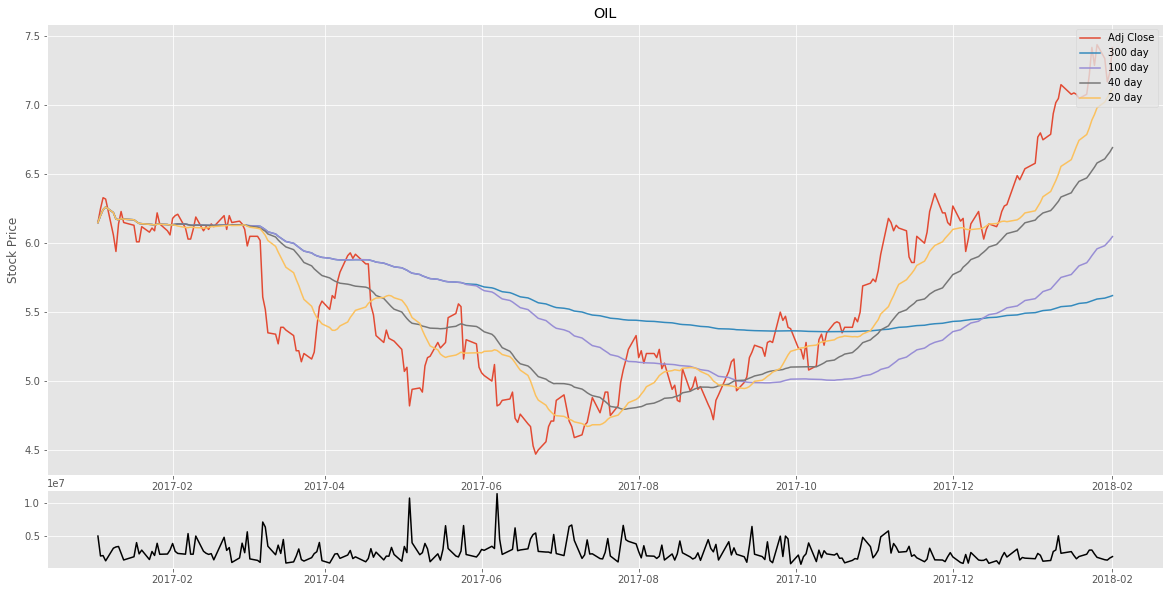

In [46]:
def main(name):
    
    name=str(name)
    start=dt.datetime(2017,1,1)
    
    #get_data_from_yahoo(True)
    
    create_csv(name,start)
    read_csv(name)
    plt.show()
    #testing_100ma_20ma(name)
    #testing_100ma_40ma(name)
    #testing_40ma_20ma(name)
    #add_double_derivative(name) #Fix this
    record_testing_results()
    
    
main('OIL')